In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d muhammadhananasghar/9-dogs-breeds-identification-classification

 98% 618M/629M [00:06<00:00, 117MB/s]
100% 629M/629M [00:06<00:00, 104MB/s]


In [ ]:
!unzip *.zip && rm -rf *.zip

In [ ]:
!rm -rf "/content/9Breeds/.ipynb_checkpoints"

In [ ]:
from keras.applications.vgg16 import VGG16

In [ ]:
img_rows, img_cols = 224, 224

model = VGG16(weights='imagenet',
              include_top=False,
              input_shape = (img_rows, img_cols, 3))

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
for layer in model.layers:
  layer.trainable = False

In [ ]:
# view the structure of the model
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
def layer_adder(bottom_model, num_classes):
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(1024, activation='relu')(top_model)
  top_model = Dense(512, activation='relu')(top_model)
  top_model = Dense(num_classes, activation='softmax')(top_model)
  return top_model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Activation, Dropout
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D, Input
from keras.layers.normalization import BatchNormalization
from keras.models import Model


num_classes = 9

FC_Head = layer_adder(model, num_classes)
model = Model(inputs = model.input, outputs = FC_Head)

print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
from keras.preprocessing.image import ImageDataGenerator


dataset_gen = ImageDataGenerator(rescale = 1./255, validation_split=0.15)

train_generator = dataset_gen.flow_from_directory(
    '/content/9Breeds',
    target_size=(img_rows, img_cols),
    batch_size=32,
    class_mode='categorical',
    subset='training') 

validation_generator = dataset_gen.flow_from_directory(
    '/content/9Breeds',
    target_size=(img_rows, img_cols),
    batch_size=32,
    class_mode='categorical',
    subset='validation')

Found 891 images belonging to 9 classes.
Found 153 images belonging to 9 classes.


In [ ]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping


checkpoint = ModelCheckpoint("dogs_breeds.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only=True,
                             verbose = 1)

earlystop = EarlyStopping(monitor="val_loss",
                         min_delta=0,
                         patience=3,
                         verbose=1,
                         restore_best_weights=True)

callbacks = [earlystop, checkpoint]

model.compile(loss="categorical_crossentropy",
              optimizer='Adam',
              metrics=['accuracy'])

In [ ]:
history = model.fit_generator(train_generator,
                              epochs = 20,
                              callbacks=callbacks,
                              validation_data=validation_generator)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
28/28 [==============================] - 81s 2s/step - loss: 2.1973 - accuracy: 0.2111 - val_loss: 1.6446 - val_accuracy: 0.4902

Epoch 00001: val_loss improved from inf to 1.64456, saving model to dogs_breeds.h5
Epoch 2/20
28/28 [==============================] - 49s 2s/step - loss: 1.4852 - accuracy: 0.5114 - val_loss: 1.2322 - val_accuracy: 0.6732

Epoch 00002: val_loss improved from 1.64456 to 1.23216, saving model to dogs_breeds.h5
Epoch 3/20
28/28 [==============================] - 51s 2s/step - loss: 1.0710 - accuracy: 0.6856 - val_loss: 0.8169 - val_accuracy: 0.7647

Epoch 00003: val_loss improved from 1.23216 to 0.81685, saving model to dogs_breeds.h5
Epoch 4/20
28/28 [==============================] - 51s 2s/step - loss: 0.7722 - accuracy: 0.7571 - val_loss: 0.7360 - val_accuracy: 0.7843

Epoch 00004: val_loss improved from 0.81685 to 0.73598, saving model to dogs_breeds.h5
Epoch 5/20
28/28 [==============================] - 50s 2s/step - loss: 0.5876 - accuracy: 0

In [ ]:
import matplotlib.pyplot as plt

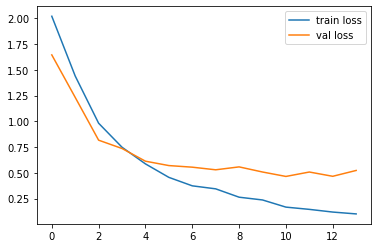

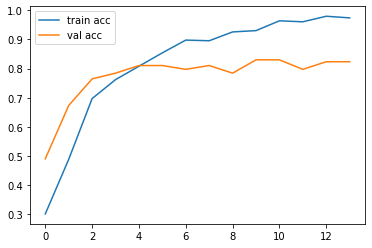

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [ ]:
from keras.models import load_model

model = load_model("/content/dogs_breeds.h5")

In [ ]:
predictions_values = train_generator.class_indices

In [ ]:
predictions_values

{'Akita Inu': 0,
 'Beagle': 1,
 'Bull Dog': 2,
 'Chihuahua': 3,
 'Dachshund': 4,
 'Golden_Retreiver': 5,
 'Poodle': 6,
 'Shih_Tzu': 7,
 'Siberian_Husky': 8}

In [ ]:
predictions = {}
for i,j in predictions_values.items():
  predictions[int(j)] = i

In [ ]:
predictions

{0: 'Akita Inu',
 1: 'Beagle',
 2: 'Bull Dog',
 3: 'Chihuahua',
 4: 'Dachshund',
 5: 'Golden_Retreiver',
 6: 'Poodle',
 7: 'Shih_Tzu',
 8: 'Siberian_Husky'}

In [ ]:
# Prediction for Image using our trained model
import numpy as np
from keras.preprocessing import image
test_image = image.load_img("/content/akita2.jpg", target_size=(224,224))
img = test_image.copy()

test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)

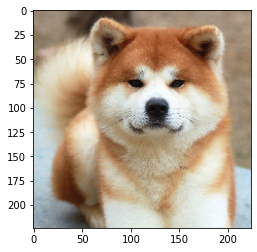

In [ ]:
plt.imshow(img)

In [ ]:
for index, value in enumerate(result[0]):
  if round(value) == 1:
    print(f"The Breed of this Dog is {predictions[index]}.")

The Breed of this Dog is Akita Inu.


In [ ]:
# Prediction for Image using our trained model
import numpy as np
from keras.preprocessing import image
test_image = image.load_img("/content/beagle.jpg", target_size=(224,224))
img = test_image.copy()

test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)

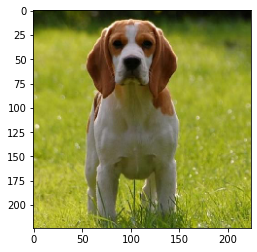

In [ ]:
plt.imshow(img)

In [ ]:
for index, value in enumerate(result[0]):
  if round(value) == 1:
    print(f"The Breed of this Dog is {predictions[index]}.")

The Breed of this Dog is Beagle.


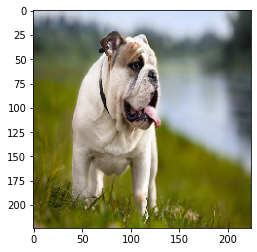

In [ ]:
# Prediction for Image using our trained model
import numpy as np
from keras.preprocessing import image
test_image = image.load_img("/content/bulldog.jpg", target_size=(224,224))
img = test_image.copy()
plt.imshow(img)

test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)

In [ ]:
for index, value in enumerate(result[0]):
  if round(value) == 1:
    print(f"The Breed of this Dog is {predictions[index]}.")

The Breed of this Dog is Bull Dog.


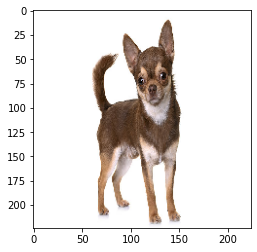

In [ ]:
# Prediction for Image using our trained model
import numpy as np
from keras.preprocessing import image
test_image = image.load_img("/content/Chihuahua.jpg", target_size=(224,224))
img = test_image.copy()
plt.imshow(img)

test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)

In [ ]:
for index, value in enumerate(result[0]):
  if round(value) == 1:
    print(f"The Breed of this Dog is {predictions[index]}.")

The Breed of this Dog is Chihuahua.


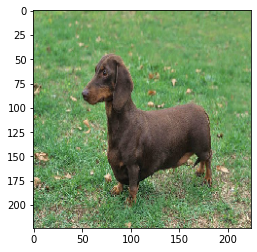

In [ ]:
# Prediction for Image using our trained model
import numpy as np
from keras.preprocessing import image
test_image = image.load_img("/content/dachshund.jpeg", target_size=(224,224))
img = test_image.copy()
plt.imshow(img)

test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)

In [ ]:
for index, value in enumerate(result[0]):
  if round(value) == 1:
    print(f"The Breed of this Dog is {predictions[index]}.")

The Breed of this Dog is Dachshund.
